In [ ]:
!pip install selenium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.7/467.7 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.0 MB/s eta 0:00:00


In [ ]:
!apt-get install chromium-driver

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'chromium-chromedriver' instead of 'chromium-driver'
The following additional packages will be installed:
  apparmor chromium-browser libfuse3-3 liblzo2-2 libudev1 snapd squashfs-tools systemd-hwe-hwdb
  udev
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser chromium-chromedriver libfuse3-3 liblzo2-2 snapd squashfs-tools
  systemd-hwe-hwdb udev
The following packages will be upgraded:
  libudev1
1 upgraded, 9 newly installed, 0 to remove and 44 not upgraded.
Need to get 28.3 MB of archives.
After this operation, 117 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 apparmor amd64 3.0.4-2ubuntu2.3 [595 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 liblzo2-2 amd64 2.10-2build3 [53.7 kB]
Get:3 http://ar

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [ ]:
def web_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--verbose")
    options.add_argument('--no-sandbox')
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument("--window-size=1920, 1200")
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=options)
    return driver

In [ ]:
driver = web_driver()

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import pandas as pd
import os
import time

url_schedule = "https://iblindonesia.com/games/schedule?season=35277&year=2023"



def fetch_element_text(driver, by, value, retries=20, delay=5):
    """Fetch the text of a web element, retrying if necessary."""
    for attempt in range(retries):
        try:
            element = driver.find_element(by, value)
            if element.is_displayed():
                return element.text
        except NoSuchElementException:
            print(f"Attempt {attempt + 1}: Element {value} not found, retrying...")
            time.sleep(delay)
    # Fallback using JavaScript
    try:
        element = driver.execute_script(f'''
            var elem = document.querySelector("{value}");
            if (elem) {{
                return elem.innerText;
            }} else {{
                return null;
            }}
        ''')
        if element:
            return element
    except Exception as e:
        print(f"JavaScript execution failed for {value}: {e}")
    return ""

def log_page_source(driver, url):
    """Log the page source for debugging purposes."""
    with open(f"page_source_{url.split('/')[-2]}.html", "w", encoding="utf-8") as file:
        file.write(driver.page_source)

def scrape_game_data(url):
    driver.get(url)
    try:
        WebDriverWait(driver, 30).until(EC.presence_of_element_located((By.CSS_SELECTOR, "div.box-score-wrap")))
    except TimeoutException:
        print(f"TimeoutException: Element not found on page {url}")
        log_page_source(driver, url)
        return

    # Get team names and scores with explicit checks and logging
    team_1_name = fetch_element_text(driver, By.CSS_SELECTOR, "div.team-0-bs .bs-team-name #aj_1_name")
    team_2_name = fetch_element_text(driver, By.CSS_SELECTOR, "div.team-1-bs .bs-team-name #aj_2_name")
    team_1_score = fetch_element_text(driver, By.ID, "aj_1_score")
    team_2_score = fetch_element_text(driver, By.ID, "aj_2_score")

    if team_1_name and team_2_name and team_1_score and team_2_score:
        print(f"Successfully extracted names and scores: {team_1_name} vs {team_2_name} with scores {team_1_score}-{team_2_score}")
    else:
        print(f"Failed to extract complete data on page {url}. Missing elements: ")
        if not team_1_name:
            print(" - Team 1 name")
        if not team_2_name:
            print(" - Team 2 name")
        if not team_1_score:
            print(" - Team 1 score")
        if not team_2_score:
            print(" - Team 2 score")
        log_page_source(driver, url)
        return

    # Function to extract player data
    def extract_player_data(players, team_name, opponent_name, team_score, opponent_score):
        for element in players:
            try:
                nomor_pemain = element.find_element(By.CSS_SELECTOR, 'td.center.num.playernum').text
                nama_pemain = element.find_element(By.CSS_SELECTOR, 'td.left.playerinfo').text
                pos = element.find_element(By.CSS_SELECTOR, 'td.center.tablet').text
                min = element.find_element(By.CSS_SELECTOR, 'td.center.center.mobile-p').text
                center_elements = element.find_elements(By.CSS_SELECTOR, 'tr > td.center')
                pts = center_elements[4].text
                FG = center_elements[5].text
                FGper = center_elements[6].text
                duaP = center_elements[7].text
                duaPer = center_elements[8].text
                tigaP = center_elements[9].text
                tigaPer = center_elements[10].text
                FT = center_elements[11].text
                FTper = center_elements[12].text
                OFF = center_elements[13].text
                DEF = center_elements[14].text
                REB = center_elements[15].text
                AST = center_elements[16].text
                TO = center_elements[17].text
                STL = center_elements[18].text
                BLK = center_elements[19].text
                BLKR = center_elements[20].text
                PF = center_elements[21].text
                FLS = center_elements[22].text
                plus = center_elements[23].text
                INDEX = center_elements[24].text

                df = pd.DataFrame([[
                    nomor_pemain, nama_pemain, pos, min, pts, FG, FGper, duaP, duaPer, tigaP, tigaPer, FT, FTper, OFF, DEF, REB, AST, TO, STL, BLK, BLKR, PF, FLS, plus, INDEX, team_name, opponent_name, team_score, opponent_score
                ]], columns=[
                    'Nomor Pemain', 'Nama Pemain', 'Posisi', 'Menit', 'PTS', 'FG', 'FG%', '2P', '2P%', '3P', '3P%', 'FT', 'FT%', 'OFF', 'DEF', 'REB', 'AST', 'TO', 'STL', 'BLK', 'BLKR', 'PF', 'FLS', 'Plus', 'INDEX', 'Nama Tim', 'Nama Tim Lawan', 'Score Tim', 'Score Tim Lawan'
                ])

                df.to_csv('data.csv', index=False, mode='a', header=not os.path.exists('data.csv'))
            except NoSuchElementException as e:
                print(f"NoSuchElementException: {e} while processing player data")

    # Extract data for both teams
    containers = driver.find_elements(By.CSS_SELECTOR, "div.box-score-wrap")
    for container in containers:
        # Extract data for team 0
        try:
            team_0_players = container.find_elements(By.XPATH, './/tbody[@class="on-court team-0-person-container" or @class="bench"]/tr')
            if team_0_players:
                extract_player_data(team_0_players, team_1_name, team_2_name, team_1_score, team_2_score)
            else:
                print(f"No players found for team 0 in container on page {url}")
        except NoSuchElementException as e:
            print(f"NoSuchElementException: {e} while processing team 0 data")

        # Extract data for team 1
        try:
            team_1_players = container.find_elements(By.XPATH, './/tbody[@class="on-court team-1-person-container" or @class="bench"]/tr')
            if team_1_players:
                extract_player_data(team_1_players, team_2_name, team_1_name, team_2_score, team_1_score)
            else:
                print(f"No players found for team 1 in container on page {url}")
        except NoSuchElementException as e:
            print(f"NoSuchElementException: {e} while processing team 1 data")

# Set to store visited URLs
visited_urls = set()

# Initialize flag for new URL found
new_url_found = True

# Loop until no new URLs are found
while new_url_found:
    new_url_found = False
    driver.get(url_schedule)

    # Find all final buttons (adjust XPath if needed)
    final_buttons = driver.find_elements(By.XPATH, "//div[@class='schedule-item']//a[@class='ga-track']")

    # Loop through each final button
    for button in final_buttons:
        url_pertandingan = button.get_attribute("href")
        url_pertandingan_bs = url_pertandingan + "/bs.html"

        # Check if URL is already visited
        if url_pertandingan_bs not in visited_urls:
            visited_urls.add(url_pertandingan_bs)
            new_url_found = True
            scrape_game_data(url_pertandingan_bs)
            # Return to the schedule page after processing data from the game page
            driver.get(url_schedule)
            break  # Exit loop after finding and processing new URL

# Close the webdriver
driver.quit()


Successfully extracted names and scores: Prawira Harum Bandung vs Pelita Jaya Bakrie Jakarta with scores 63-58
Successfully extracted names and scores: Pelita Jaya Bakrie Jakarta vs Prawira Harum Bandung with scores 65-74
Successfully extracted names and scores: Satria Muda Pertamina Jakarta vs Pelita Jaya Bakrie Jakarta with scores 84-87
Successfully extracted names and scores: Prawira Harum Bandung vs Dewa United Banten with scores 88-80
Successfully extracted names and scores: Dewa United Banten vs Prawira Harum Bandung with scores 74-83
Successfully extracted names and scores: Pelita Jaya Bakrie Jakarta vs Satria Muda Pertamina Jakarta with scores 80-67
Successfully extracted names and scores: Satria Muda Pertamina Jakarta vs Bali United Basketball with scores 75-67
Successfully extracted names and scores: Prawira Harum Bandung vs Bumi Borneo Basketball Pontianak with scores 85-73
Successfully extracted names and scores: Bali United Basketball vs Satria Muda Pertamina Jakarta with 

In [ ]:
import pandas as pd


In [ ]:
df = pd.read_csv('/content/data.csv')

In [ ]:
display(df)

,Nomor Pemain,Nama Pemain,Posisi,Menit,PTS,FG,FG%,2P,2P%,3P,...,BLK,BLKR,PF,FLS,Plus,INDEX,Nama Tim,Nama Tim Lawan,Score Tim,Score Tim Lawan
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Prawira Harum Bandung,Pelita Jaya Bakrie Jakarta,63,58
1,8.0,Y. Saputera,PG,40:00,20.0,7-18,38.0,3-7,42.0,4-11,...,0.0,0.0,1.0,4.0,5.0,15.0,Prawira Harum Bandung,Pelita Jaya Bakrie Jakarta,63,58
2,16.0,J. Shaw,C,29:60,27.0,10-19,52.0,10-16,62.0,0-3,...,1.0,0.0,3.0,8.0,2.0,33.0,Prawira Harum Bandung,Pelita Jaya Bakrie Jakarta,63,58
3,19.0,M. Fahdani Guntara\n(C),PF,29:32,5.0,0-4,0.0,0-2,0.0,0-2,...,0.0,0.0,1.0,5.0,3.0,14.0,Prawira Harum Bandung,Pelita Jaya Bakrie Jakarta,63,58
4,24.0,I. Muhammad,SF,6:29,0.0,0-1,0.0,0-0,0.0,0-1,...,0.0,0.0,2.0,0.0,0.0,-2.0,Prawira Harum Bandung,Pelita Jaya Bakrie Jakarta,63,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,9.0,S. Asyurna,PG,5:58,0.0,0-0,0.0,0-0,0.0,0-0,...,0.0,0.0,1.0,0.0,-2.0,-1.0,RJ Amartha Hangtuah Jakarta,Bali United Basketball,75,71
10104,12.0,J. Desmet,PG,6:45,2.0,1-2,50.0,1-1,100.0,0-1,...,0.0,0.0,1.0,1.0,5.0,5.0,RJ Amartha Hangtuah Jakarta,Bali United Basketball,75,71
10105,13.0,G. Gunawan,SF,20:12,7.0,3-6,50.0,2-3,66.0,1-3,...,0.0,0.0,0.0,2.0,11.0,11.0,RJ Amartha Hangtuah Jakarta,Bali United Basketball,75,71
10106,22.0,E. Malou,SF/PF,20:41,23.0,7-14,50.0,4-6,66.0,3-8,...,1.0,0.0,1.0,4.0,6.0,23.0,RJ Amartha Hangtuah Jakarta,Bali United Basketball,75,71


In [ ]:


# Hapus baris yang mengandung nilai NaN atau null
df_cleaned = df.dropna()

# Simpan DataFrame yang sudah dibersihkan ke dalam file CSV baru
df_cleaned.to_csv('data_cleaned.csv', index=False)

In [ ]:
df = pd.read_csv('/content/data_cleaned.csv')

In [ ]:
display(df)

,Nomor Pemain,Nama Pemain,Posisi,Menit,PTS,FG,FG%,2P,2P%,3P,...,BLK,BLKR,PF,FLS,Plus,INDEX,Nama Tim,Nama Tim Lawan,Score Tim,Score Tim Lawan
0,8.0,Y. Saputera,PG,40:00,20.0,7-18,38.0,3-7,42.0,4-11,...,0.0,0.0,1.0,4.0,5.0,15.0,Prawira Harum Bandung,Pelita Jaya Bakrie Jakarta,63,58
1,16.0,J. Shaw,C,29:60,27.0,10-19,52.0,10-16,62.0,0-3,...,1.0,0.0,3.0,8.0,2.0,33.0,Prawira Harum Bandung,Pelita Jaya Bakrie Jakarta,63,58
2,19.0,M. Fahdani Guntara\n(C),PF,29:32,5.0,0-4,0.0,0-2,0.0,0-2,...,0.0,0.0,1.0,5.0,3.0,14.0,Prawira Harum Bandung,Pelita Jaya Bakrie Jakarta,63,58
3,24.0,I. Muhammad,SF,6:29,0.0,0-1,0.0,0-0,0.0,0-1,...,0.0,0.0,2.0,0.0,0.0,-2.0,Prawira Harum Bandung,Pelita Jaya Bakrie Jakarta,63,58
4,77.0,M. Guntara,SF,28:39,2.0,1-5,20.0,1-3,33.0,0-2,...,0.0,1.0,4.0,3.0,-4.0,-3.0,Prawira Harum Bandung,Pelita Jaya Bakrie Jakarta,63,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9589,9.0,S. Asyurna,PG,5:58,0.0,0-0,0.0,0-0,0.0,0-0,...,0.0,0.0,1.0,0.0,-2.0,-1.0,RJ Amartha Hangtuah Jakarta,Bali United Basketball,75,71
9590,12.0,J. Desmet,PG,6:45,2.0,1-2,50.0,1-1,100.0,0-1,...,0.0,0.0,1.0,1.0,5.0,5.0,RJ Amartha Hangtuah Jakarta,Bali United Basketball,75,71
9591,13.0,G. Gunawan,SF,20:12,7.0,3-6,50.0,2-3,66.0,1-3,...,0.0,0.0,0.0,2.0,11.0,11.0,RJ Amartha Hangtuah Jakarta,Bali United Basketball,75,71
9592,22.0,E. Malou,SF/PF,20:41,23.0,7-14,50.0,4-6,66.0,3-8,...,1.0,0.0,1.0,4.0,6.0,23.0,RJ Amartha Hangtuah Jakarta,Bali United Basketball,75,71


Data Asli:
   Nomor Pemain              Nama Pemain Posisi  Menit   PTS     FG   FG%  \
0           NaN                      NaN    NaN    NaN   NaN    NaN   NaN   
1           8.0              Y. Saputera     PG  40:00  20.0   7-18  38.0   
2          16.0                  J. Shaw      C  29:60  27.0  10-19  52.0   
3          19.0  M. Fahdani Guntara\n(C)     PF  29:32   5.0    0-4   0.0   
4          24.0              I. Muhammad     SF   6:29   0.0    0-1   0.0   

      2P   2P%    3P  ...  BLK BLKR   PF  FLS  Plus  INDEX  \
0    NaN   NaN   NaN  ...  NaN  NaN  NaN  NaN   NaN    NaN   
1    3-7  42.0  4-11  ...  0.0  0.0  1.0  4.0   5.0   15.0   
2  10-16  62.0   0-3  ...  1.0  0.0  3.0  8.0   2.0   33.0   
3    0-2   0.0   0-2  ...  0.0  0.0  1.0  5.0   3.0   14.0   
4    0-0   0.0   0-1  ...  0.0  0.0  2.0  0.0   0.0   -2.0   

                Nama Tim              Nama Tim Lawan  Score Tim  \
0  Prawira Harum Bandung  Pelita Jaya Bakrie Jakarta         63   
1  Prawira Harum Ba

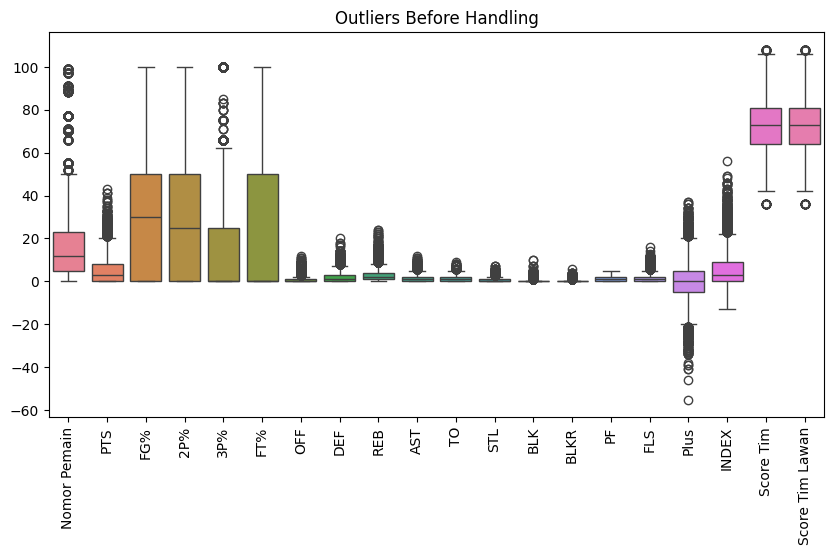

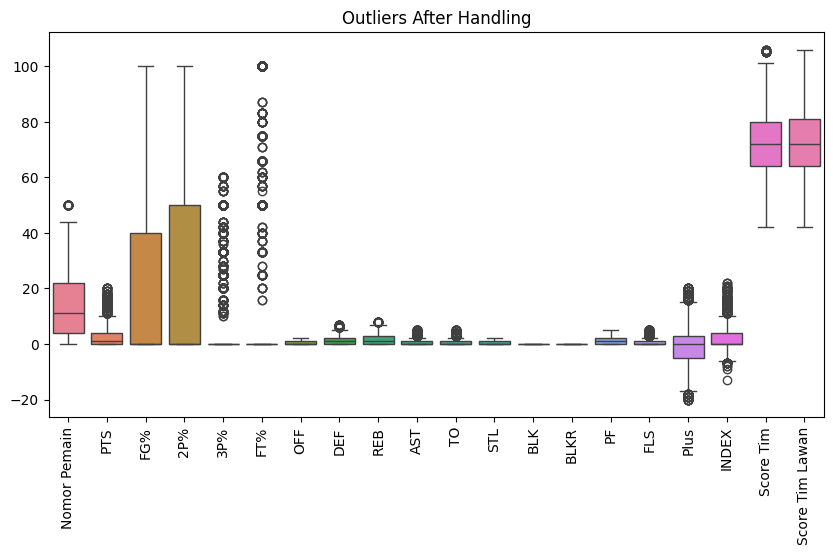

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Membaca data dari file CSV
df = pd.read_csv('data.csv')

# Menampilkan beberapa baris pertama dari data asli
print("Data Asli:")
print(df.head())

# Menghapus baris yang mengandung nilai NaN atau null
df_cleaned = df.dropna()

# Menampilkan beberapa baris pertama dari data setelah menghapus NaN
print("\nData Setelah Menghapus NaN:")
print(df_cleaned.head())

# Fungsi untuk mengatasi outlier menggunakan metode IQR
def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_no_outliers = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
    return df_no_outliers

# Mengatasi outlier pada data yang sudah dibersihkan dari nilai NaN
df_no_outliers = remove_outliers_iqr(df_cleaned.select_dtypes(include=np.number))

# Menampilkan beberapa baris pertama dari data setelah mengatasi outlier
print("\nData Setelah Mengatasi Outlier:")
print(df_no_outliers.head())

# Menampilkan statistik dasar untuk data asli, data setelah menghapus NaN, dan data setelah mengatasi outlier
print("\nStatistik Data Asli:")
print(df.describe())

print("\nStatistik Data Setelah Menghapus NaN:")
print(df_cleaned.describe())

print("\nStatistik Data Setelah Mengatasi Outlier:")
print(df_no_outliers.describe())

# Menyimpan DataFrame yang sudah dibersihkan ke dalam file CSV baru
df_no_outliers.to_csv('data_cleaned_no_outliers.csv', index=False)

# Membuat grafik untuk menunjukkan outlier sebelum dan sesudah penanganan
# Grafik sebelum penanganan outlier
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_cleaned.select_dtypes(include=np.number))
plt.title('Outliers Before Handling')
plt.xticks(rotation=90)
plt.show()

# Grafik sesudah penanganan outlier
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_no_outliers)
plt.title('Outliers After Handling')
plt.xticks(rotation=90)
plt.show()


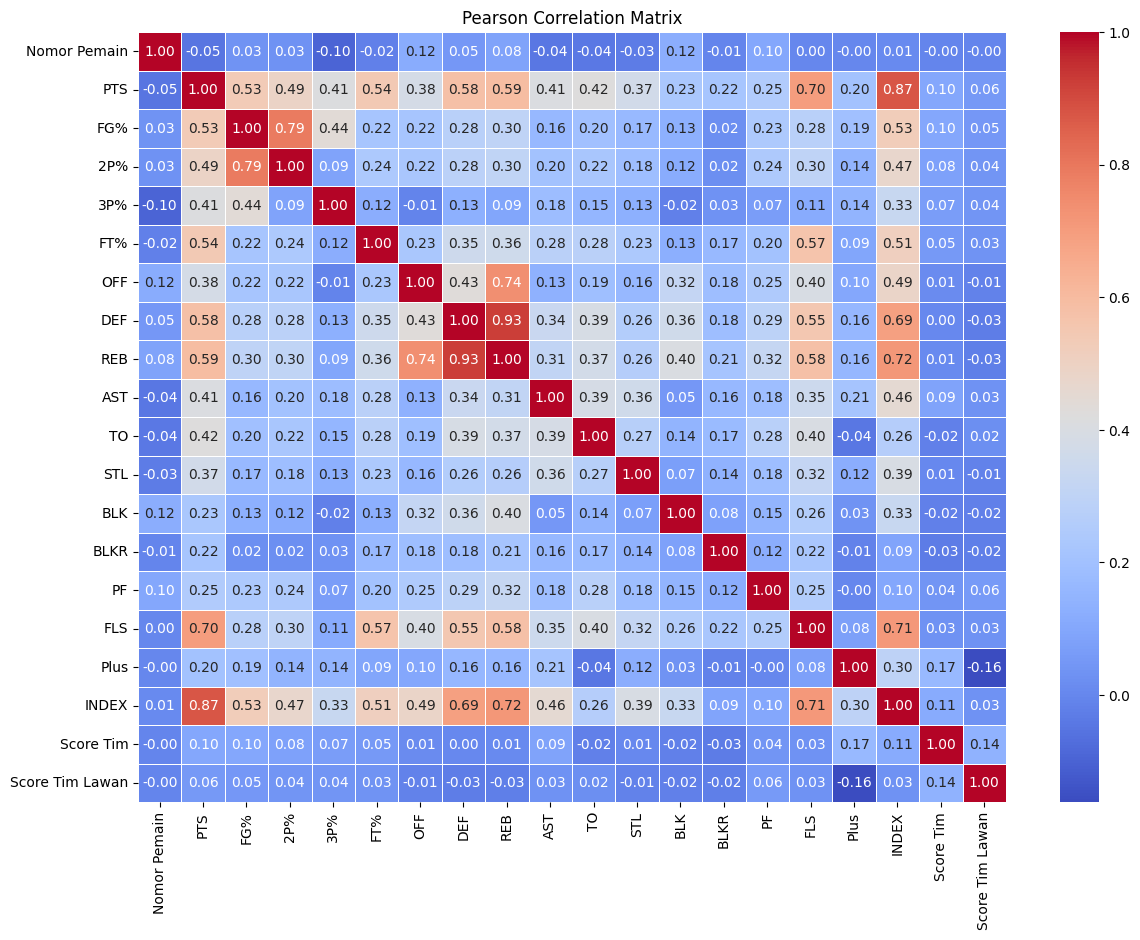

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load the data
file_path = 'corrected_data.csv'
data = pd.read_csv(file_path)

# Drop the first row which seems to be empty or irrelevant
data = data.drop(0)

# Convert the 'Menit' column from "mm:ss" format to decimal format
def convert_to_minutes(time_str):
    if isinstance(time_str, str):
        minutes, seconds = map(int, time_str.split(':'))
        return minutes + seconds / 60
    return time_str

data['Menit'] = data['Menit'].apply(convert_to_minutes)

# Convert columns to appropriate data types
numeric_columns = ['Nomor Pemain', 'PTS', 'FG%', '2P%', '3P%', 'FT%', 'OFF', 'DEF', 'REB', 'AST', 'TO', 'STL', 'BLK', 'BLKR', 'PF', 'FLS', 'Plus', 'INDEX', 'Score Tim', 'Score Tim Lawan']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaN values in numeric columns
data = data.dropna(subset=numeric_columns)

# Calculate Pearson correlation
correlation_matrix = data[numeric_columns].corr(method='pearson')

# Plotting the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title("Pearson Correlation Matrix")
plt.show()


In [ ]:
import pandas as pd

# Load the existing data
data = pd.read_csv('data.csv')

# Ensure all necessary columns are present
required_columns = ['Nomor Pemain', 'Nama Pemain', 'Posisi', 'Menit', 'PTS', 'FG', 'FG%', '2P', '2P%', '3P', '3P%', 'FT', 'FT%', 'OFF', 'DEF', 'REB', 'AST', 'TO', 'STL', 'BLK', 'BLKR', 'PF', 'FLS', 'Plus', 'INDEX', 'Nama Tim', 'Nama Tim Lawan', 'Score Tim', 'Score Tim Lawan']
missing_columns = [column for column in required_columns if column not in data.columns]
if missing_columns:
    raise ValueError(f"Input data is missing the following required columns: {missing_columns}")

# Debug: Print initial data
print("Initial data:")
print(data.head())

# Convert the 'Menit' column to numeric, forcing errors to NaN
data['Menit'] = pd.to_numeric(data['Menit'].str.replace(':', '.'), errors='coerce')

# Debug: Print data after conversion
print("Data after converting 'Menit' to numeric:")
print(data[['Menit']].head())

# Drop rows where 'Menit' is NaN
data = data.dropna(subset=['Menit'])

# Check if there is any data left after dropping NaNs
if data.empty:
    raise ValueError("No valid data left after dropping rows with NaN values in 'Menit' column.")

# Debug: Print first few rows of data
print("Data after dropping NaNs and converting 'Menit' to numeric:")
print(data.head())

# Group by match (Nama Tim, Nama Tim Lawan, Score Tim, Score Tim Lawan) and position (Posisi)
grouped = data.groupby(['Nama Tim', 'Nama Tim Lawan', 'Score Tim', 'Score Tim Lawan', 'Posisi'])

# Find the top player in each position for each match based on the highest minutes played
def get_top_player(group):
    top_player = group.loc[group['Menit'].idxmax()]
    return top_player

top_players = grouped.apply(get_top_player)

# Reset index to make the DataFrame easier to work with
top_players = top_players.reset_index(drop=True)

# Debug: Print first few rows of top players data
print("Top players data:")
print(top_players.head())

# Reorder columns to have a clean output
output_columns = ['Nama Tim', 'Nama Tim Lawan', 'Score Tim', 'Score Tim Lawan', 'Posisi', 'Nomor Pemain', 'Nama Pemain', 'Menit', 'PTS', 'FG', 'FG%', '2P', '2P%', '3P', '3P%', 'FT', 'FT%', 'OFF', 'DEF', 'REB', 'AST', 'TO', 'STL', 'BLK', 'BLKR', 'PF', 'FLS', 'Plus', 'INDEX']
top_players = top_players[output_columns]

# Save the final result to a new CSV file
top_players.to_csv('top_players_by_position.csv', index=False)

print("The top players by position have been successfully saved to 'top_players_by_position.csv'.")


Initial data:
   Nomor Pemain              Nama Pemain Posisi  Menit   PTS     FG   FG%  \
0           NaN                      NaN    NaN    NaN   NaN    NaN   NaN   
1           8.0              Y. Saputera     PG  40:00  20.0   7-18  38.0   
2          16.0                  J. Shaw      C  29:60  27.0  10-19  52.0   
3          19.0  M. Fahdani Guntara\n(C)     PF  29:32   5.0    0-4   0.0   
4          24.0              I. Muhammad     SF   6:29   0.0    0-1   0.0   

      2P   2P%    3P  ...  BLK BLKR   PF  FLS  Plus  INDEX  \
0    NaN   NaN   NaN  ...  NaN  NaN  NaN  NaN   NaN    NaN   
1    3-7  42.0  4-11  ...  0.0  0.0  1.0  4.0   5.0   15.0   
2  10-16  62.0   0-3  ...  1.0  0.0  3.0  8.0   2.0   33.0   
3    0-2   0.0   0-2  ...  0.0  0.0  1.0  5.0   3.0   14.0   
4    0-0   0.0   0-1  ...  0.0  0.0  2.0  0.0   0.0   -2.0   

                Nama Tim              Nama Tim Lawan  Score Tim  \
0  Prawira Harum Bandung  Pelita Jaya Bakrie Jakarta         63   
1  Prawira Harum

In [ ]:
import pandas as pd

# Load the existing data
data = pd.read_csv('data.csv')

# Ensure all necessary columns are present
required_columns = ['Nama Tim', 'Nama Tim Lawan', 'Score Tim', 'Score Tim Lawan', 'Nomor Pemain', 'Nama Pemain', 'Posisi', 'Menit']
missing_columns = [column for column in required_columns if column not in data.columns]
if missing_columns:
    raise ValueError(f"Input data is missing the following required columns: {missing_columns}")

# Convert the 'Menit' column to numeric, replacing any ':' with '.', forcing errors to NaN
data['Menit'] = pd.to_numeric(data['Menit'].str.replace(':', '.'), errors='coerce')

# Drop rows where 'Menit' is NaN
data = data.dropna(subset=['Menit'])

# Define the positions of interest
positions = ['C', 'PF', 'SF', 'SG', 'PG']

# Initialize list to store final results
final_results = []

# Function to process each team's match data
def process_team_match(group, team, opponent, team_score, opponent_score):
    # Filter the group for the specific team
    team_group = group[group['Nama Tim'] == team]

    # Check if the team_group is empty
    if team_group.empty:
        print(f"No data found for team {team} in match against {opponent}")
        return None

    # Sort players by 'Menit' in descending order
    sorted_group = team_group.sort_values(by='Menit', ascending=False)

    # Debug: Check the sorted group for each team
    print(f"\nProcessing match: {team} vs {opponent}")
    print(f"Sorted group for {team}:")
    print(sorted_group[['Nama Pemain', 'Posisi', 'Menit']].head(10))

    # Initialize dictionary to store top players
    match_result = {
        'Nama Tim': team,
        'Nama Tim Lawan': opponent,
        'Score Tim': team_score,
        'Score Tim Lawan': opponent_score,
        'Top Player C': None,
        'Top Player PF': None,
        'Top Player SF': None,
        'Top Player SG': None,
        'Top Player PG': None,
        'Next Top Player': None
    }

    # Identify the top player for each position
    used_players = set()
    for pos in positions:
        top_player = sorted_group[(sorted_group['Posisi'] == pos) & (~sorted_group['Nomor Pemain'].isin(used_players))].head(1)
        if not top_player.empty:
            match_result[f'Top Player {pos}'] = top_player['Nama Pemain'].values[0]
            used_players.add(top_player['Nomor Pemain'].values[0])

    # Get the next player with the highest minutes not in top 5 positions
    next_top_player = sorted_group[~sorted_group['Nomor Pemain'].isin(used_players)].head(1)
    if not next_top_player.empty:
        match_result['Next Top Player'] = next_top_player['Nama Pemain'].values[0]

    return match_result

# Group by match (Nama Tim, Nama Tim Lawan, Score Tim, Score Tim Lawan)
grouped = data.groupby(['Nama Tim', 'Nama Tim Lawan', 'Score Tim', 'Score Tim Lawan'])

# Process each match and compile the results
for (team, opponent, team_score, opponent_score), group in grouped:
    # Process the match for the home team
    home_result = process_team_match(group, team, opponent, team_score, opponent_score)
    if home_result:
        final_results.append(home_result)

    # Process the match for the away team
    away_result = process_team_match(group, opponent, team, opponent_score, team_score)
    if away_result:
        final_results.append(away_result)

# Convert results to DataFrame
final_df = pd.DataFrame(final_results)

# Debug: Print first few rows and the structure of the DataFrame
print("\nFirst few rows of the final DataFrame:")
print(final_df.head(10))

print("\nStructure of the final DataFrame:")
print(final_df.info())

# Save the final result to a new CSV file
final_df.to_csv('top_players_summary.csv', index=False)

print("\nThe top players summary has been successfully saved to 'top_players_summary.csv'.")


Streaming output truncated to the last 5000 lines.
6409          C. Winata    F/G  20.00
6411        T. Hartanto      C  18.49
6406         P. Hosbach   C/PF  18.33
6410            D. Haye   C/PF  17.01
6395        K. Purwanto     PG  12.48
No data found for team RJ Amartha Hangtuah Jakarta in match against Evos Thunder Bogor

Processing match: Evos Thunder Bogor vs Satria Muda Pertamina Jakarta
Sorted group for Evos Thunder Bogor:
         Nama Pemain Posisi  Menit
6104       C. Winata    F/G  28.51
6099      A. Jackson    F/G  22.24
6109          L. Oei     PF  21.18
6107   R. Butarbutar     PF  21.17
6100  A. Christianto     SG  20.55
6111         M. Aziz     SG  19.25
6110    H. Hardianus     PG  18.24
6114        A. Wisnu     SF  17.59
6105         D. Haye   C/PF  17.36
6101      P. Hosbach   C/PF  16.48
No data found for team Satria Muda Pertamina Jakarta in match against Evos Thunder Bogor

Processing match: Evos Thunder Bogor vs Satria Muda Pertamina Jakarta
Sorted group for Ev

In [ ]:
df = pd.read_csv('/content/cleaned_team_summary_with_players_in_one_row.csv')

In [ ]:
display(df)

,Nama Tim,Nama Tim Lawan,Score Tim,Score Tim Lawan,Player 1 PTS,Player 1 FG,Player 1 2P,Player 1 3P,Player 1 FT,Player 1 AST,...,Player 6 PTS,Player 6 FG,Player 6 2P,Player 6 3P,Player 6 FT,Player 6 AST,Player 6 STL,Player 6 BLK,Player 6 TO,Player 6 PF
0,1,2,75,87,11.0,4.0,2.0,2.0,1.0,2.0,...,3.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0,1.0,2.0
1,1,2,83,77,2.0,0.0,0.0,0.0,2.0,1.0,...,17.0,6.0,5.0,1.0,4.0,5.0,1.0,0.0,2.0,4.0
2,1,3,81,85,8.0,4.0,4.0,0.0,0.0,0.0,...,5.0,1.0,0.0,1.0,2.0,3.0,1.0,0.0,6.0,1.0
3,1,3,89,62,6.0,1.0,1.0,0.0,4.0,2.0,...,14.0,5.0,1.0,4.0,0.0,1.0,2.0,0.0,1.0,2.0
4,1,4,66,85,15.0,6.0,5.0,1.0,2.0,3.0,...,4.0,2.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,16,15,63,52,6.0,2.0,2.0,0.0,2.0,0.0,...,2.0,1.0,1.0,0.0,0.0,5.0,3.0,0.0,3.0,3.0
506,16,15,63,84,5.0,2.0,2.0,0.0,1.0,2.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
507,3,2,77,86,25.0,10.0,9.0,1.0,4.0,3.0,...,10.0,4.0,4.0,0.0,2.0,0.0,3.0,5.0,1.0,1.0
508,3,7,68,60,9.0,3.0,3.0,0.0,3.0,2.0,...,3.0,1.0,0.0,1.0,0.0,4.0,0.0,1.0,1.0,2.0


In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/cleaned_team_summary_with_players_in_one_row.csv'
data = pd.read_csv(file_path)

# Create a dictionary to map team names to unique numbers
team_name_to_number = {}
current_number = 1

# Function to get or assign a number to a team
def get_or_assign_number(team_name):
    global current_number
    if team_name not in team_name_to_number:
        team_name_to_number[team_name] = current_number
        current_number += 1
    return team_name_to_number[team_name]

# Function to unify specified teams
def unify_teams(team_number):
    if team_number in [3, 4, 18, 19]:
        return 3
    return team_number

# Apply the function to unify teams
data['Nama Tim'] = data['Nama Tim'].apply(get_or_assign_number)
data['Nama Tim Lawan'] = data['Nama Tim Lawan'].apply(get_or_assign_number)
data['Nama Tim'] = data['Nama Tim'].apply(unify_teams)
data['Nama Tim Lawan'] = data['Nama Tim Lawan'].apply(unify_teams)

# Re-map the team numbers sequentially
unique_teams = sorted(data['Nama Tim'].unique())
new_team_name_to_number = {team: i + 1 for i, team in enumerate(unique_teams)}
data['Nama Tim'] = data['Nama Tim'].map(new_team_name_to_number)
data['Nama Tim Lawan'] = data['Nama Tim Lawan'].map(new_team_name_to_number)

# Save the modified data to a new CSV file
modified_file_path = '/content/renumbered_top_players_summary_filtered.csv'
data.to_csv(modified_file_path, index=False)

print(f"The modified data has been saved to '{modified_file_path}'.")


The modified data has been saved to '/content/renumbered_top_players_summary_filtered.csv'.


In [ ]:
import pandas as pd

# Memuat data yang telah dibersihkan dan diubah menjadi numerik
summary_path = '/content/processed_top_players_summary.csv'
data_path = '/content/data.csv'

summary_data = pd.read_csv(summary_path)
player_data = pd.read_csv(data_path)

# Membuat kolom baru untuk menggabungkan Nama Tim dan Nama Tim Lawan
summary_data['Match'] = summary_data.apply(lambda x: f"{x['Nama Tim']} vs {x['Nama Tim Lawan']} ({x['Score Tim']}-{x['Score Tim Lawan']})", axis=1)

# Inisialisasi list untuk menyimpan data summary
summary_rows = []

# Kelompokkan data berdasarkan pertandingan
grouped = summary_data.groupby(['Nama Tim', 'Nama Tim Lawan', 'Score Tim', 'Score Tim Lawan'])

# Proses setiap grup
for (nama_tim, nama_tim_lawan, score_tim, score_tim_lawan), group in grouped:
    # Buat dictionary untuk menyimpan data baris
    row = {
        'Nama Tim': nama_tim,
        'Nama Tim Lawan': nama_tim_lawan,
        'Score Tim': score_tim,
        'Score Tim Lawan': score_tim_lawan,
    }

    # Dapatkan data pemain untuk pertandingan tersebut
    match_data = player_data[
        (player_data['Nama Tim'] == nama_tim) &
        (player_data['Nama Tim Lawan'] == nama_tim_lawan) &
        (player_data['Score Tim'] == score_tim) &
        (player_data['Score Tim Lawan'] == score_tim_lawan)
    ]

    if match_data.empty:
        print(f"No match data found for {nama_tim} vs {nama_tim_lawan} ({score_tim}-{score_tim_lawan})")
        continue

    # Tambahkan data pemain ke baris
    for i, (_, player_row) in enumerate(match_data.iterrows()):
        row[f'Player {i+1} PTS'] = player_row['PTS']
        row[f'Player {i+1} FG'] = player_row['FG']
        row[f'Player {i+1} 2P'] = player_row['2P']
        row[f'Player {i+1} 3P'] = player_row['3P']
        row[f'Player {i+1} FT'] = player_row['FT']
        row[f'Player {i+1} REB'] = player_row['REB']
        row[f'Player {i+1} AST'] = player_row['AST']
        row[f'Player {i+1} STL'] = player_row['STL']
        row[f'Player {i+1} BLK'] = player_row['BLK']
        row[f'Player {i+1} TO'] = player_row['TO']
        row[f'Player {i+1} PF'] = player_row['PF']
        row[f'Player {i+1} Plus'] = player_row['Plus']
        row[f'Player {i+1} INDEX'] = player_row['INDEX']

    # Tambahkan baris ke summary_rows
    summary_rows.append(row)

# Membuat DataFrame dari summary_rows
summary_df = pd.DataFrame(summary_rows)

# Menyimpan DataFrame ke file CSV
output_path = 'team_summary_with_players_in_one_row.csv'
summary_df.to_csv(output_path, index=False)

print(f"Data summary per tim dengan pemain telah disimpan ke '{output_path}'.")


Data summary per tim dengan pemain telah disimpan ke 'team_summary_with_players_in_one_row.csv'.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the CSV is loaded correctly
data_path = '/content/cleaned_team_summary_with_results.csv'

# Load the data
data = pd.read_csv(data_path)

# Drop non-numeric columns for correlation calculation
numeric_data = data.select_dtypes(include='number')

# Calculate the correlation matrix using Pearson method
correlation_matrix = numeric_data.corr(method='pearson')

# Generate a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/renumbered_top_players_summary_filtered.csv'
data = pd.read_csv(file_path)

# Remove columns related to 'REB', 'Plus', and 'INDEX'
columns_to_remove = [col for col in data.columns if 'Player 1 Nama' in col or 'Player 2 Nama' in col or'Player 3 Nama' in col or'Player 4 Nama' in col or'Player 5 Nama' in col or'Player 6 Nama' in col or'Menit' in col or 'Posisi' in col or'REB' in col or 'Plus' in col or 'INDEX' in col]
data = data.drop(columns=columns_to_remove, errors='ignore')

cleaned_file_path = 'cleaned_team_summary_with_players_in_one_row.csv'
data.to_csv(cleaned_file_path, index=False)

print(f"The cleaned data has been saved to '{cleaned_file_path}'.")

The cleaned data has been saved to 'cleaned_team_summary_with_players_in_one_row.csv'.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = 'cleaned_team_summary_with_players_in_one_row.csv'
data = pd.read_csv(file_path)

# Split the data into training and testing sets (80-20 split)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Save the training and testing sets to new CSV files
train_file_path = 'train_team_summary.csv'
test_file_path = 'test_team_summary.csv'
train_data.to_csv(train_file_path, index=False)
test_data.to_csv(test_file_path, index=False)

print(f"The training data has been saved to '{train_file_path}'.")
print(f"The testing data has been saved to '{test_file_path}'.")


The training data has been saved to 'train_team_summary.csv'.
The testing data has been saved to 'test_team_summary.csv'.


In [ ]:
pip install pandas scikit-learn joblib


In [ ]:
import pandas as pd

# Load the filtered CSV file
filtered_file_path = '/content/filtered_data.csv'
filtered_data = pd.read_csv(filtered_file_path)

# Remove any leading or trailing whitespace characters from column names
filtered_data.columns = filtered_data.columns.str.strip()

# Group by "Nama Pemain" and "Nama Tim" and count the occurrences
team_counts = filtered_data.groupby(['Nama Pemain', 'Nama Tim']).size().reset_index(name='count')

# Determine the most frequent team for each player
most_frequent_team = team_counts.loc[team_counts.groupby('Nama Pemain')['count'].idxmax()]

# Create a dictionary mapping players to their most frequent team
player_team_map = dict(zip(most_frequent_team['Nama Pemain'], most_frequent_team['Nama Tim']))

# Replace the team name for each player with their most frequent team
filtered_data['Nama Tim'] = filtered_data['Nama Pemain'].map(player_team_map)

# Save the corrected data to a new CSV file
corrected_file_path = 'corrected_data.csv'
filtered_data.to_csv(corrected_file_path, index=False)

corrected_file_path


'corrected_data.csv'

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/data.csv'
data = pd.read_csv(file_path)

# Filter out rows where 'Nama Tim' or 'Nama Tim Lawan' contains 'tim feature' or 'tim legacy'
filtered_data = data[
    ~data['Nama Tim'].str.contains('TEAM FUTURE|TEAM LEGACY', case=False, na=False) &
    ~data['Nama Tim Lawan'].str.contains('TEAM FUTURE|TEAM LEGACY', case=False, na=False)
]

# Save the filtered data to a new CSV file
filtered_file_path = 'filtered_data.csv'
filtered_data.to_csv(filtered_file_path, index=False)



In [ ]:
import pandas as pd

# Load the CSV file
file_path = 'corrected_data.csv'
data = pd.read_csv(file_path)

# Drop rows where all elements are NaN
data.dropna(how='all', inplace=True)

# Remove unwanted columns
data.drop(columns=['INDEX', 'Plus', 'Nama Tim Lawan', 'Score Tim', 'Score Tim Lawan'], inplace=True)

# Convert columns with '-' to only take the first value before '-'
def take_first_value(value):
    if isinstance(value, str) and '-' in value:
        return int(value.split('-')[0])
    try:
        return int(value)
    except ValueError:
        return 0

columns_with_dash = ['FG', '2P', '3P', 'FT']
for col in columns_with_dash:
    data[col] = data[col].apply(take_first_value)

# Convert 'Menit' to total seconds as a float
def convert_time_to_seconds(time_str):
    if pd.isna(time_str):
        return 0
    time_parts = time_str.split(':')
    return int(time_parts[0]) * 60 + int(time_parts[1])

data['Menit'] = data['Menit'].apply(convert_time_to_seconds)

# Convert other columns to numeric, errors='coerce' will turn non-convertible values into NaN
numeric_columns = ['Menit', 'PTS', 'FG%', '2P%', '3P%', 'FT%', 'OFF', 'DEF', 'REB', 'AST', 'TO', 'STL', 'BLK', 'PF']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Standardize player names by removing the '(C)' marker
data['Nama Pemain'] = data['Nama Pemain'].str.replace(r'\s*\(C\)', '', regex=True)

# Initialize the aggregated data frame
agg_data = data.groupby(['Nama Pemain', 'Posisi', 'Nama Tim']).first().reset_index()
agg_data[numeric_columns] = 0

# Initialize a dictionary to store sums and counts
player_sums = {col: {} for col in numeric_columns}
player_counts = {}

# Perform the iterative calculation
for idx, row in data.iterrows():
    player = row['Nama Pemain']
    position = row['Posisi']
    team = row['Nama Tim']
    key = (player, position, team)

    if key not in player_counts:
        player_counts[key] = 0
    player_counts[key] += 1

    for col in numeric_columns:
        if key not in player_sums[col]:
            player_sums[col][key] = 0
        player_sums[col][key] += row[col]

# Calculate the averages and assign them back to agg_data
for col in numeric_columns:
    for key, total_sum in player_sums[col].items():
        player, position, team = key
        count = player_counts[key]
        avg_value = total_sum // count  # Use integer division to avoid decimals
        mask = (agg_data['Nama Pemain'] == player) & (agg_data['Posisi'] == position) & (agg_data['Nama Tim'] == team)
        agg_data.loc[mask, col] = avg_value

# Convert 'Menit' back to minutes
def convert_seconds_to_time(seconds):
    minutes = int(seconds // 60)
    seconds = int(seconds % 60)
    return f"{minutes}:{seconds:02d}"

agg_data['Menit'] = agg_data['Menit'].apply(convert_seconds_to_time)

# Save the final data to a CSV file
output_file_path = 'aggregated_player_statistics_corrected.csv'
agg_data.to_csv(output_file_path, index=False)

output_file_path


'aggregated_player_statistics_corrected.csv'

In [ ]:
import pandas as pd

# Load the aggregated data
file_path = '/content/aggregated_player_statistics_corrected (1).csv'
aggregated_data = pd.read_csv(file_path)

# Convert 'Menit' column to numeric, forcing errors to NaN
aggregated_data['Menit'] = pd.to_numeric(aggregated_data['Menit'], errors='coerce')

# Remove unwanted columns except 'Menit'
columns_to_remove = ['2P%', '3P%', 'FT%', 'FG%', 'FLS', 'BLKR', 'OFF', 'DEF', 'REB', 'Nomor Pemain']
aggregated_data.drop(columns=columns_to_remove, inplace=True)

# Define the best players for each team
best_players = {
    'Bali United Basketball': [],
    'RJ Amartha Hangtuah Jakarta': ['D. Pratama', 'F. Amir', 'G. Saputra', 'Z. Talley Jr', 'R. Delph'],
    'Bima Perkasa Jogja': ['A. Kurniawan', 'J. De Smet', 'M. Kimbrough', 'G. Holloman', 'R. Purnomo'],
    'Bumi Borneo Basketball Pontianak': ['S. Orlando', 'S. Rondonuwu', 'M. Qualls', 'S. Taylor Jr', 'J. Johnson'],
    'Dewa United Banten': ['H. Hardianus', 'J. Adams', 'T. Miller', 'K. Gemilang', 'L. Prosper'],
    'West Bandits Solo': ['T. Johns', 'S. Susanto', 'N. Saputra', 'K. Eliazer Poetiray', 'K. Barkley'],
    'Elang Pacific Caesar Surabaya': [],
    'Pelita Jaya Bakrie Jakarta': ['T. Robinson', 'M. Arighi', 'M. Richardson', 'A. Dhyaksa', 'M. Fahdani Guntara'],
    'Prawira Harum Bandung': ['Y. Saputera', 'B. Francis', 'J. Gist Iii', 'P. Wiguna', 'M. Guntara'],
    'Evos Thunder Bogor': ['R. Pamungkas', 'J. Bergstedt', 'H. Thio', 'P. Mcglynn Iv', 'J. Wongso'],
    'RANS PIK Basketball Club': ['O. Sanjaya', 'D. Oostrum', 'L. Nash', 'D. Salamena', 'J. Jordan'],
    'Satria Muda Pertamina Jakarta': ['D. Diagne', 'A. Grahita', 'J. Shaw', 'A. Wisnu', 'W. Teja'],
    'Satya Wacana Salatiga': ['T. Robinson', 'I. Asrat', 'C. Biyantaka', 'T. Saputro', 'R. Prasetya'],
    'Tangerang Hawks Basketball Club': ['A. Jr.', 'D. Ray', 'X. Alexander', 'T. Romadonsyah', 'F. Mailangkay']
}

positions = ['C', 'SG', 'PF', 'PG', 'SF']

best_players_per_team = []

for team, players in best_players.items():
    team_data = aggregated_data[aggregated_data['Nama Tim'] == team]
    selected_players = []
    used_players = set()

    if team == 'Bali United Basketball' or team == 'Elang Pacific Caesar Surabaya':
        # Select players for Bali United Basketball and Elang Pacific Caesar Surabaya based on position with the most minutes
        for pos in positions:
            pos_players = team_data[team_data['Posisi'] == pos]
            if not pos_players.empty:
                best_pos_player = pos_players.sort_values(by='Menit', ascending=False).iloc[0]
                selected_players.append(best_pos_player)
                used_players.add(best_pos_player['Nama Pemain'])
    else:
        # Select specified players and ensure they are in the correct team
        for player_name in players:
            # First try to find exact matches
            player_data = aggregated_data[aggregated_data['Nama Pemain'] == player_name]
            if not player_data.empty:
                player_record = player_data.iloc[0].copy()
                selected_players.append(player_record)
                used_players.add(player_name)

        # Fill remaining slots with the best players from different positions based on minutes played
        for pos in positions:
            if len(selected_players) >= 6:
                break
            pos_players = team_data[team_data['Posisi'] == pos]
            remaining_players = pos_players[~pos_players['Nama Pemain'].isin(used_players)]
            if not remaining_players.empty:
                best_remaining_player = remaining_players.sort_values(by='Menit', ascending=False).iloc[0]
                selected_players.append(best_remaining_player)
                used_players.add(best_remaining_player['Nama Pemain'])

        # If still not enough players, select based on the most minutes remaining
        if len(selected_players) < 6:
            remaining_players = team_data[~team_data['Nama Pemain'].isin(used_players)]
            while len(selected_players) < 6 and not remaining_players.empty:
                best_remaining_player = remaining_players.sort_values(by='Menit', ascending=False).iloc[0]
                selected_players.append(best_remaining_player)
                used_players.add(best_remaining_player['Nama Pemain'])
                remaining_players = remaining_players[remaining_players['Nama Pemain'] != best_remaining_player['Nama Pemain']]

    # Combine the selected players into a single row per team
    team_row = {
        'Nama Tim': team,
    }
    for i, player in enumerate(selected_players, 1):
        for col in aggregated_data.columns:
            if col not in ['Nama Tim', 'Posisi', 'Menit']:
                team_row[f'Player {i}_{col}'] = player[col]
        # Include player name
        team_row[f'Player {i}_Nama Pemain'] = player['Nama Pemain']

    best_players_per_team.append(team_row)

# Ensure no statistics are missing
for team_row in best_players_per_team:
    for i in range(1, 7):  # Players 1 to 6
        player_key = f'Player {i}_Nama Pemain'
        if player_key not in team_row:
            for pos in positions:
                pos_players = aggregated_data[(aggregated_data['Nama Tim'] == team_row['Nama Tim']) & (aggregated_data['Posisi'] == pos)]
                pos_players = pos_players[~pos_players['Nama Pemain'].isin([team_row.get(f'Player {j}_Nama Pemain', '') for j in range(1, 7)])]
                if not pos_players.empty:
                    best_pos_player = pos_players.sort_values(by='Menit', ascending=False).iloc[0]
                    for col in aggregated_data.columns:
                        if col not in ['Nama Tim', 'Posisi', 'Menit']:
                            team_row[f'Player {i}_{col}'] = best_pos_player[col]
                    team_row[f'Player {i}_Nama Pemain'] = best_pos_player['Nama Pemain']
                    break

# Create a DataFrame from the collected data
best_players_df = pd.DataFrame(best_players_per_team)

# Save the final data to a CSV file
output_file_path = 'best_players_per_team_withName.csv'
best_players_df.to_csv(output_file_path, index=False)

print(f"The final data has been saved to '{output_file_path}'")


The final data has been saved to 'best_players_per_team_withName.csv'


In [ ]:
import pandas as pd

# Load the existing best players data
best_players_file_path = '/content/best_players_per_team_withName.csv'
best_players_df = pd.read_csv(best_players_file_path)

# Remove player name columns
player_name_columns = [col for col in best_players_df.columns if 'Nama Pemain' in col]
best_players_df.drop(columns=player_name_columns, inplace=True)

# Create a dictionary to map team names to numbers
team_names = best_players_df['Nama Tim'].unique()
team_to_number = {team: i+1 for i, team in enumerate(team_names)}
number_to_team = {i+1: team for i, team in enumerate(team_names)}

# Create a list to store the match data with stats
match_data = []

# Iterate over each team and create matches against all other teams
for team in team_names:
    opponents = [opponent for opponent in team_names if opponent != team]
    team_data = best_players_df[best_players_df['Nama Tim'] == team].iloc[0]
    for opponent in opponents:
        match = team_data.copy()
        match['Nama Tim'] = team_to_number[team]
        match['Nama Tim Lawan'] = team_to_number[opponent]
        match_data.append(match)

# Create a DataFrame from the match data
matches_df = pd.DataFrame(match_data)

# Ensure 'Nama Tim' and 'Nama Tim Lawan' columns are integer type
matches_df['Nama Tim'] = matches_df['Nama Tim'].astype(int)
matches_df['Nama Tim Lawan'] = matches_df['Nama Tim Lawan'].astype(int)

# Move the 'Nama Tim Lawan' column to be next to the 'Nama Tim' column
columns = list(matches_df.columns)
columns.insert(columns.index('Nama Tim') + 1, columns.pop(columns.index('Nama Tim Lawan')))
matches_df = matches_df[columns]

# Remove underscores from column names
matches_df.columns = [col.replace('_', ' ') for col in matches_df.columns]

# Save the match data to a CSV file
output_file_path = 'match_schedule_with_stats.csv'
matches_df.to_csv(output_file_path, index=False)
print(f"Match data saved to '{output_file_path}'")

# Function to convert numbers back to team names
def convert_numbers_to_team_names(df, number_to_team):
    df['Nama Tim'] = df['Nama Tim'].map(number_to_team)
    df['Nama Tim Lawan'] = df['Nama Tim Lawan'].map(number_to_team)
    return df

# Example of converting numbers back to team names
converted_df = convert_numbers_to_team_names(matches_df.copy(), number_to_team)
print(converted_df.head())

# Verify original data remains unchanged
print(best_players_df.head())


Match data saved to 'match_schedule_with_stats.csv'
                 Nama Tim                    Nama Tim Lawan  Player 1 PTS  \
0  Bali United Basketball       RJ Amartha Hangtuah Jakarta          15.0   
0  Bali United Basketball                Bima Perkasa Jogja          15.0   
0  Bali United Basketball  Bumi Borneo Basketball Pontianak          15.0   
0  Bali United Basketball                Dewa United Banten          15.0   
0  Bali United Basketball                 West Bandits Solo          15.0   

   Player 1 FG  Player 1 2P  Player 1 3P  Player 1 FT  Player 1 AST  \
0            5            4            1            6           0.0   
0            5            4            1            6           0.0   
0            5            4            1            6           0.0   
0            5            4            1            6           0.0   
0            5            4            1            6           0.0   

   Player 1 TO  Player 1 STL  ...  Player 6 PTS  Player 6 

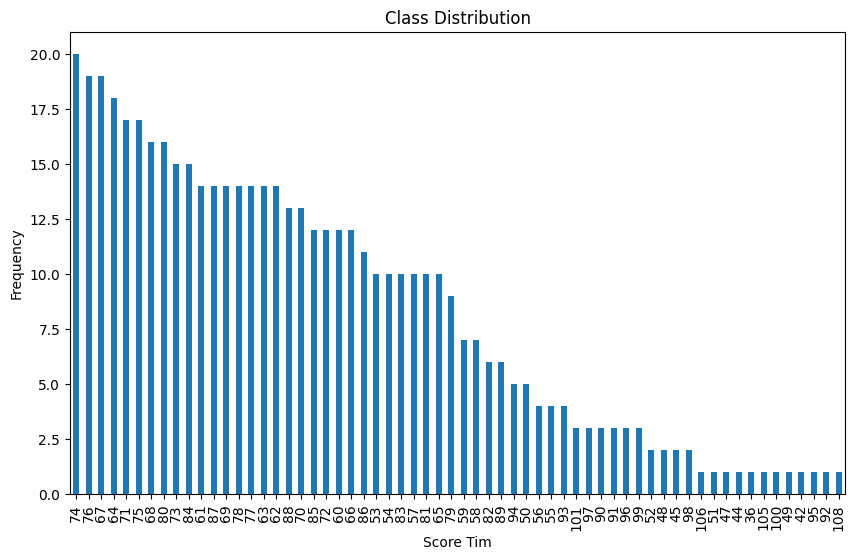

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'cleaned_team_summary_with_players_in_one_row.csv'
data = pd.read_csv(file_path)

# Check class distribution
target_column = 'Score Tim'
class_counts = data[target_column].value_counts()
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Score Tim')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import pandas as pd

# Baca file CSV
file_path = 'cleaned_team_summary_with_players_in_one_row.csv'
df = pd.read_csv(file_path)

# Menghitung selisih skor
df['score_diff'] = df['Score Tim'] - df['Score Tim Lawan']

# Membuat kolom 'hasil' berdasarkan selisih skor
df['hasil'] = df['score_diff'].apply(lambda x: 1 if x > 0 else (0 if x < 0 else 2))

# Buat DataFrame baru tanpa kolom 'score_diff'
new_df = df.drop(columns=['score_diff'])

# Simpan DataFrame baru ke file CSV
result_file_path = 'cleaned_team_summary_with_results.csv'
new_df.to_csv(result_file_path, index=False)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
import joblib

# Load data
file_path = 'cleaned_team_summary_with_players_in_one_row.csv'
data = pd.read_csv(file_path)

# Pisahkan fitur dan target
X = data.drop(columns=['Score Tim', 'Score Tim Lawan'])
y = data[['Score Tim', 'Score Tim Lawan']]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', ExtraTreesRegressor())
])

# Define the parameter grid
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_features': ['auto', 'sqrt', 'log2'],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Randomized search
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=50, cv=5, verbose=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best estimator
best_model = random_search.best_estimator_

# Predict the test set
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

# Evaluate the model
mape_score_tim_test = mean_absolute_percentage_error(y_test['Score Tim'], y_pred_test[:, 0])
mape_score_tim_lawan_test = mean_absolute_percentage_error(y_test['Score Tim Lawan'], y_pred_test[:, 1])

mape_score_tim_train = mean_absolute_percentage_error(y_train['Score Tim'], y_pred_train[:, 0])
mape_score_tim_lawan_train = mean_absolute_percentage_error(y_train['Score Tim Lawan'], y_pred_train[:, 1])

print(f'MAPE Score Tim (Test): {mape_score_tim_test}')
print(f'MAPE Score Tim Lawan (Test): {mape_score_tim_lawan_test}')
print(f'MAPE Score Tim (Train): {mape_score_tim_train}')
print(f'MAPE Score Tim Lawan (Train): {mape_score_tim_lawan_train}')

# Save the model
joblib.dump(best_model, 'best_extra_trees_model_pipeline.pkl')

# Display top important features
importances = best_model.named_steps['regressor'].feature_importances_
features = X.columns
feature_importances = pd.Series(importances, index=features).sort_values(ascending=False)
print('Top Important Features:')
print(feature_importances)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


MAPE Score Tim (Test): 0.13316410749586494
MAPE Score Tim Lawan (Test): 0.12641440413226462
MAPE Score Tim (Train): 0.026435588280964924
MAPE Score Tim Lawan (Train): 0.027985315261774977
Top Important Features:
Nama Tim          0.054635
Nama Tim Lawan    0.042179
Player 5 AST      0.032062
Player 1 PF       0.031769
Player 6 3P       0.029851
                    ...   
Player 4 FT       0.010438
Player 6 2P       0.010186
Player 4 STL      0.009646
Player 2 BLK      0.008830
Player 5 FT       0.008525
Length: 62, dtype: float64


In [ ]:
import pandas as pd
import joblib
from sklearn.impute import SimpleImputer

# Load the dataset
file_path = 'match_schedule_with_stats.csv'
data = pd.read_csv(file_path)

# Load the trained model
model_file_path = '/content/best_extra_trees_model_pipeline (1).pkl'
model = joblib.load(model_file_path)

# Define the features (keep only the features that were used to train the model)
expected_feature_names = model.feature_names_in_
features = data[expected_feature_names]

# Impute missing values in the features
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

# Predict scores
predicted_scores = model.predict(features_imputed)

# Ensure predicted_scores are 2D
if predicted_scores.ndim == 1:
    raise ValueError("Predicted scores should be a 2D array with two columns for each match.")

# Calculate the difference in scores to determine the result
data['Predicted Score Tim'] = predicted_scores[:, 0]
data['Predicted Score Tim Lawan'] = predicted_scores[:, 1]
data['Score Difference'] = data['Predicted Score Tim'] - data['Predicted Score Tim Lawan']

# Determine win or lose based on score difference
data['Predicted Result'] = data['Score Difference'].apply(lambda x: 'Menang' if x > 0 else 'Kalah')

# Assuming you have the correct team_numbers_to_names mapping
# This should be replaced with the actual mapping of team numbers to names
team_numbers_to_names = {
    1: 'Bali United Basketbal',
    2: 'RJ Amartha Hangtuah Jakarta',
    3: 'Bima Perkasa Jogja',
    4: 'Borneo Hornbills',
    5: 'Dewa United Banten',
    6: 'Kesatria Bengawan Solo',
    7: 'Pacific Caesar Surabaya',
    8: 'Pelita Jaya Jakarta',
    9: 'Prawira Harum Bandung',
    10: 'Rajawali Medan',
    11: 'RANS Simba Bogor',
    12: 'Satria Muda Pertamina Jakarta',
    13: 'Satya Wacana Salatiga',
    14: 'Tangerang Hawks Basketball Club',
}

# Function to convert numbers to team names
def convert_numbers_to_team_names(df, number_to_team):
    df['Nama Tim'] = df['Nama Tim'].map(number_to_team)
    df['Nama Tim Lawan'] = df['Nama Tim Lawan'].map(number_to_team)
    return df

# Convert team numbers to team names
data = convert_numbers_to_team_names(data, team_numbers_to_names)

# Check for any NaN values in 'Nama Tim' or 'Nama Tim Lawan' columns and handle them
data['Nama Tim'].fillna('Unknown Team', inplace=True)
data['Nama Tim Lawan'].fillna('Unknown Team', inplace=True)

# Print results in the desired format
for index, row in data.iterrows():
    tim_name = row['Nama Tim']
    predicted_score = row['Predicted Score Tim']
    opponent_name = row['Nama Tim Lawan']
    opponent_score = row['Predicted Score Tim Lawan']
    result = row['Predicted Result']
    print(f"{tim_name} {predicted_score} vs {opponent_score} {opponent_name}: {tim_name} {result}")

# Save the predictions to a new CSV file
predictions_file_path = 'predicted_match_results.csv'
data.to_csv(predictions_file_path, index=False)
print(f"The predicted match results have been saved to '{predictions_file_path}'.")


Bali United Basketbal 67.93333333333334 vs 70.18333333333334 RJ Amartha Hangtuah Jakarta: Bali United Basketbal Kalah
Bali United Basketbal 67.94333333333333 vs 70.05333333333333 Bima Perkasa Jogja: Bali United Basketbal Kalah
Bali United Basketbal 67.84666666666666 vs 70.07333333333334 Borneo Hornbills: Bali United Basketbal Kalah
Bali United Basketbal 67.83 vs 69.89 Dewa United Banten: Bali United Basketbal Kalah
Bali United Basketbal 67.82333333333334 vs 69.58 Kesatria Bengawan Solo: Bali United Basketbal Kalah
Bali United Basketbal 67.96333333333334 vs 69.66 Pacific Caesar Surabaya: Bali United Basketbal Kalah
Bali United Basketbal 67.70333333333333 vs 69.92666666666666 Pelita Jaya Jakarta: Bali United Basketbal Kalah
Bali United Basketbal 67.83 vs 70.41666666666667 Prawira Harum Bandung: Bali United Basketbal Kalah
Bali United Basketbal 67.83 vs 70.31 Rajawali Medan: Bali United Basketbal Kalah
Bali United Basketbal 67.9 vs 70.17666666666666 RANS Simba Bogor: Bali United Basketbal

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd

# Load the provided CSV files
standings_1 = pd.read_csv('/content/standings (1).csv')
real_standing = pd.read_csv('real_standing.csv')

# Merge the dataframes based on the team name
merged_df = pd.merge(standings_1, real_standing, on="Team")

# Calculate the rank difference between real standings and provided standings
merged_df['Rank Difference'] = merged_df['Rank'] - merged_df.index

# Sum the rank differences
sum_rank_diff = merged_df['Rank Difference'].sum()

# Number of teams
num_teams = len(merged_df)

# Calculate the average rank difference
average_rank_diff = sum_rank_diff / num_teams

# Calculate the standard deviation of the rank differences
std_dev_rank_diff = merged_df['Rank Difference'].std()

print("Average Rank Difference:", average_rank_diff)
print("Standard Deviation of Rank Difference:", std_dev_rank_diff)


Average Rank Difference: 1.8333333333333333
Standard Deviation of Rank Difference: 3.809875524889431


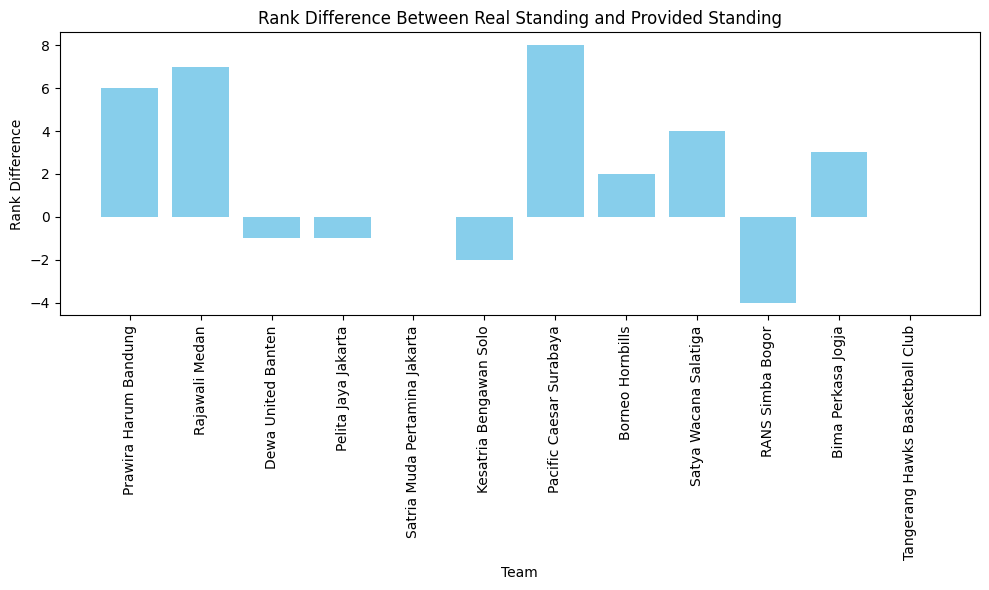

In [ ]:
import matplotlib.pyplot as plt

# Visualize the rank differences for each team
plt.figure(figsize=(10, 6))
plt.bar(merged_df['Team'], merged_df['Rank Difference'], color='skyblue')
plt.xlabel('Team')
plt.ylabel('Rank Difference')
plt.title('Rank Difference Between Real Standing and Provided Standing')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load the predicted match results
predicted_file_path = 'predicted_match_results.csv'
predicted_data = pd.read_csv(predicted_file_path)

# Initialize a dictionary to store the standings
standings = {
    'Team': [],
    'Win Home': [],
    'Lose Home': [],
    'Win Away': [],
    'Lose Away': [],
    'Total Wins': [],
    'Total Losses': [],
    'Points': []
}

# Get unique team names
teams = pd.concat([predicted_data['Nama Tim'], predicted_data['Nama Tim Lawan']]).unique()

# Initialize standings for each team
for team in teams:
    standings['Team'].append(team)
    standings['Win Home'].append(0)
    standings['Lose Home'].append(0)
    standings['Win Away'].append(0)
    standings['Lose Away'].append(0)
    standings['Total Wins'].append(0)
    standings['Total Losses'].append(0)
    standings['Points'].append(0)

# Create a DataFrame for the standings
standings_df = pd.DataFrame(standings)

# Update the standings based on the predicted results
for index, row in predicted_data.iterrows():
    home_team = row['Nama Tim']
    away_team = row['Nama Tim Lawan']
    result = row['Predicted Result']

    if result == 'Menang':
        # Home team wins
        standings_df.loc[standings_df['Team'] == home_team, 'Win Home'] += 1
        standings_df.loc[standings_df['Team'] == home_team, 'Total Wins'] += 1
        standings_df.loc[standings_df['Team'] == home_team, 'Points'] += 2

        # Away team loses
        standings_df.loc[standings_df['Team'] == away_team, 'Lose Away'] += 1
        standings_df.loc[standings_df['Team'] == away_team, 'Total Losses'] += 1
        standings_df.loc[standings_df['Team'] == away_team, 'Points'] += 1
    else:
        # Away team wins
        standings_df.loc[standings_df['Team'] == away_team, 'Win Away'] += 1
        standings_df.loc[standings_df['Team'] == away_team, 'Total Wins'] += 1
        standings_df.loc[standings_df['Team'] == away_team, 'Points'] += 2

        # Home team loses
        standings_df.loc[standings_df['Team'] == home_team, 'Lose Home'] += 1
        standings_df.loc[standings_df['Team'] == home_team, 'Total Losses'] += 1
        standings_df.loc[standings_df['Team'] == home_team, 'Points'] += 1

# Sort the standings by points
standings_df = standings_df.sort_values(by='Points', ascending=False)

# Save the standings to a new CSV file
standings_file_path = 'standings.csv'
standings_df.to_csv(standings_file_path, index=False)

print(f"The standings have been saved to '{standings_file_path}'.")


The standings have been saved to 'standings.csv'.


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Fetch the webpage content
url = 'https://iblindonesia.com/games/standing'
response = requests.get(url)
webpage_content = response.content

# Parse HTML content
soup = BeautifulSoup(webpage_content, 'html.parser')

# Locate and extract standings data
standings_table = soup.find('table')
rows = standings_table.find_all('tr')[1:]  # Skip the header row

standings_data = []
for row in rows:
    cols = row.find_all('td')
    rank = cols[0].text.strip()
    team = cols[1].text.strip()
    games = cols[2].text.strip()
    wins = cols[3].text.strip()
    losses = cols[4].text.strip()
    points = cols[5].text.strip()

    standings_data.append({
        'Rank': rank,
        'Team': team,
        'Games': games,
        'Wins': wins,
        'Losses': losses,
        'Points': points
    })

# Store data in a DataFrame
standings_df = pd.DataFrame(standings_data)

# Save DataFrame to a CSV file
standings_df.to_csv('real_standing.csv', index=False)

# Print confirmation message
print("Standings data has been saved to 'real_standing.csv'")


Standings data has been saved to 'real_standing.csv'


In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Load the real standings CSV file
real_standing_path = 'real_standing.csv'
real_standing_df = pd.read_csv(real_standing_path)

# Load the predicted standings CSV file
predicted_standing_path = '/content/standings (1).csv'
predicted_standing_df = pd.read_csv(predicted_standing_path)

# Merge the two dataframes on the 'Team' column
merged_df = real_standing_df.merge(predicted_standing_df, on='Team', suffixes=('_real', '_predicted'))

# Rename columns for clarity
merged_df.rename(columns={'Wins': 'Wins_real', 'Losses': 'Losses_real', 'Total Wins': 'Wins_predicted', 'Total Losses': 'Losses_predicted'}, inplace=True)

# Calculate win percentages for both real and predicted standings
merged_df['Win_Percentage_real'] = merged_df['Wins_real'] / merged_df['Games']
merged_df['Win_Percentage_predicted'] = merged_df['Wins_predicted'] / (merged_df['Wins_predicted'] + merged_df['Losses_predicted'])

# Binarize the win percentages: 1 for above 0.5, 0 for 0.5 or below
threshold = 0.5
merged_df['Win_real'] = merged_df['Win_Percentage_real'] > threshold
merged_df['Win_predicted'] = merged_df['Win_Percentage_predicted'] > threshold

# Calculate precision, recall, F1 score, and accuracy
precision = precision_score(merged_df['Win_real'], merged_df['Win_predicted'])
recall = recall_score(merged_df['Win_real'], merged_df['Win_predicted'])
f1 = f1_score(merged_df['Win_real'], merged_df['Win_predicted'])
accuracy = accuracy_score(merged_df['Win_real'], merged_df['Win_predicted'])

# Display the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")


Precision: 0.71
Recall: 0.83
F1 Score: 0.77
Accuracy: 0.75


In [ ]:
import pandas as pd
import numpy as np

# Load the real standings CSV file provided by the user
real_standing_path = 'real_standing.csv'
real_standing_df = pd.read_csv(real_standing_path)

# Load the predicted standings CSV file provided by the user
predicted_standing_path = 'standings.csv'
predicted_standing_df = pd.read_csv(predicted_standing_path)

# Filter data to include only the current season (assumption: current season is 2024)
current_season = 2024
if 'Season' in real_standing_df.columns:
    real_standing_df = real_standing_df[real_standing_df['Season'] == current_season]
if 'Season' in predicted_standing_df.columns:
    predicted_standing_df = predicted_standing_df[predicted_standing_df['Season'] == current_season]

# Calculate the accuracy for each team in the real standings
real_standing_df['Accuracy'] = real_standing_df['Wins'] / real_standing_df['Games']

# Calculate the total wins and games for the predicted standings
predicted_standing_df['Total Games'] = predicted_standing_df['Total Wins'] + predicted_standing_df['Total Losses']
predicted_standing_df['Accuracy'] = predicted_standing_df['Total Wins'] / predicted_standing_df['Total Games']

# Merge the two dataframes on the 'Team' column
merged_df = real_standing_df.merge(predicted_standing_df, on='Team', suffixes=('_real', '_predicted'))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = (abs(merged_df['Accuracy_real'] - merged_df['Accuracy_predicted']) / merged_df['Accuracy_real']).mean() * 100

# Calculate Mean Squared Error (MSE)
mse = ((merged_df['Accuracy_real'] - merged_df['Accuracy_predicted']) ** 2).mean() * 100

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Display the results
results = {
    'MAPE (%)': mape,
    'MSE (%)': mse,
    'RMSE (%)': rmse
}



results



{'MAPE (%)': 77.36797924297925,
 'MSE (%)': 6.008498453845141,
 'RMSE (%)': 2.4512238685695644}

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/standings (1).csv'  # Change this to your actual file path
standings_df = pd.read_csv(file_path)

# Calculate the win percentage
standings_df['Win Percentage'] = (standings_df['Total Wins'] / (standings_df['Total Wins'] + standings_df['Total Losses'])) * 100

# Sort teams by Total Wins (descending) and then by Total Losses (ascending)
standings_df = standings_df.sort_values(by=['Total Wins', 'Total Losses'], ascending=[False, True])

# Assign rank based on the sorted order
standings_df['Rank'] = range(1, len(standings_df) + 1)

# Reorder columns for better readability
standings_df = standings_df[['Rank', 'Team', 'Win Home', 'Lose Home', 'Win Away', 'Lose Away', 'Total Wins', 'Total Losses', 'Points', 'Win Percentage']]

# Save the updated DataFrame to a new CSV file
output_file_path = 'updated_standings.csv'  # Change this to your desired output file path
standings_df.to_csv(output_file_path, index=False)

print(f"Updated standings saved to {output_file_path}")


Updated standings saved to updated_standings.csv


In [ ]:
import pandas as pd

# Load the CSV files
predicted_file_path = 'standings (1).csv'  # Change this to your actual file path
real_file_path = 'real_standing.csv'  # Change this to your actual file path

predicted_df = pd.read_csv(predicted_file_path)
real_df = pd.read_csv(real_file_path)

# Calculate the win percentage for the predicted standings
predicted_df['Win Percentage'] = (predicted_df['Total Wins'] / (predicted_df['Total Wins'] + predicted_df['Total Losses'])) * 100

# Sort teams by Total Wins (descending) and then by Total Losses (ascending) for predicted standings
predicted_df = predicted_df.sort_values(by=['Total Wins', 'Total Losses'], ascending=[False, True])

# Extract the team names in the order of the standings
predicted_standings_names = predicted_df['Team'].reset_index(drop=True)
real_standings_names = real_df['Team'].reset_index(drop=True)

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Real Standings': real_standings_names,
    'Predicted Standings': predicted_standings_names
})

# Save the comparison DataFrame to a new CSV file
output_file_path = 'comparison_standings.csv'  # Change this to your desired output file path
comparison_df.to_csv(output_file_path, index=False)

print(f"Comparison standings saved to {output_file_path}")


Comparison standings saved to comparison_standings.csv
